In [1]:
%load_ext autoreload
%autoreload 2

# Multislice Simulations

THe multislice algorithm works by incrementally stepping the 2d lateral part of the wave function forward along the optical axis. A step forward through a slice of the potential consists of a transmission and a propagation. The `Wave` objects can be transmitted through a potential slice, which in the weak-phase approximation is just a phase shift. To complete a forward step the transmitted wave is propagated by the thickness of the slice using in the fresnel approximation.

We import the potential from the previous tutorial and set up a plane wave with an energy of 300 keV.

In [3]:
from abtem.potentials import ArrayPotential
from abtem.waves import PlaneWave
import numpy as np
potential = ArrayPotential.read('srtio3_110_potential.hdf5')

In [5]:
wave = PlaneWave(energy=300e3)
wave.grid.match(potential)

The complete multislice algorithm just repeats this for all slices sequentially, hence it can be implemented as the following loop.

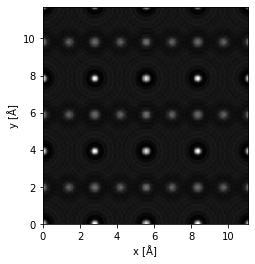

In [6]:
from abtem.waves import FresnelPropagator, transmit

wave = wave.build()
propagator = FresnelPropagator()
for potential_slice in potential:
    wave = transmit(wave, potential_slice)
    wave = propagator.propagate(wave, potential_slice.thickness)

wave.show();

We obviously don't want write this code every time, hence the the above loop can be executed using `.multislice` method. We store the result.

In [8]:
from abtem.potentials import Potential

exit_wave = PlaneWave(energy=300e3).multislice(potential)

exit_wave.write('srtio3_exit_wave.hdf5')

A diffraction pattern typically has a very large dynamic range in its intensity. The low spatial frequency information (low scattering angle) has a large amplitude but the high spatial frequency information (high scattering angle) has a much lower amplitude. The high spatial frequency information (which is frequently the interesting part) is not visible if the diffraction pattern is normalized to fill the available grey scale in a linear manner. It is to common to transform the intensities as:

$$
\log(1 + c |F(k_x,k_y)|^2) \quad ,
$$

where $F(k_x, k_y)$ is the Fourier transform of the image and the constant $c$ can be varied to adjust the contrast.

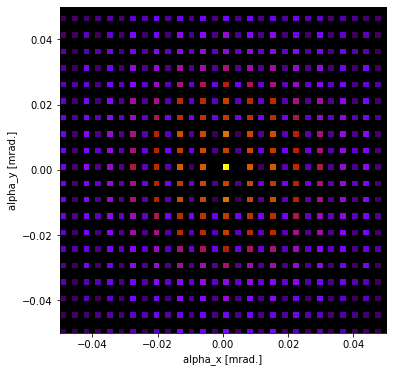

In [14]:
ax, im = exit_wave.diffraction_pattern().show(display_func=lambda x: np.log(1 + 1e-4 * x), figsize=(6,6), cmap='gnuplot')

ax.set_xlim([-.05,.05])
ax.set_ylim([-.05,.05]);

## Compatible grids

You may have noted that the grid of the wave function was not given above. Using the multislice function, the wave function just adopts the grid of the potential before starting the multislice propagation. On the other hand, the following will result in a runtime error because the sampling cannot be inferred from the information given.

```python
wave = PlaneWave(energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)
```

The next bit of code will also result in an error because the sampling of the wave function and the potential is different.

```python
wave = PlaneWaves(sampling=.1, energy=300e3)
potential = Potential(atoms, sampling=.05)
exit_wave = wave.multislice(potential)
```

## Probe wave function multislice simulation

Imaging modes utilizing an electron probe requires us to provide a position for the probe. Otherwise it works the same.

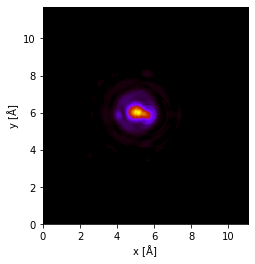

In [15]:
from abtem.waves import Probe

probe = Probe(energy=200e3, semiangle_cutoff=.02)

exit_wave = probe.multislice((5,6), potential)

exit_wave.show(cmap='gnuplot')

In convergent beam electron diffraction, we want the intensity of wave function at the diffraction plane. This is equivalent to the power spectra of the wave function. This can be calculated

The square modulus of the Fourier transform of a function is called its power spectra. The power spectra of the wave function transmitted through the specimen is also equivalent to the electron diffraction pattern of the specimen. numpy can be used for calculate the power spectra of a wave function.

In [16]:
diffraction_patterns = exit_wave.diffraction_pattern()

(-0.2, 0.2)

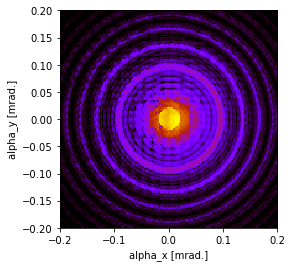

In [17]:
import numpy as np

ax, im = diffraction_patterns.show(display_func=lambda x: np.log(1+.00001*x), cmap='gnuplot')
ax.set_xlim([-.2,.2])
ax.set_ylim([-.2,.2])